In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import unc_calc_funcs as ucf

In [2]:
%matplotlib widget

In [3]:

temp_table = np.array([0, 20, 35, 50])
temp_table = temp_table + 273.15

Ps_mmHg, Ps_kPa = ucf.calculate_Ps(T_K = temp_table)

print(Ps_mmHg, Ps_kPa)

[ 4.58445395 17.53942105 42.18999885 92.6439359 ] [ 0.61121     2.33839617  5.62486819 12.35150373]


In [ ]:
# reference conditions
RH_ref = 60 # % RH
T_C_ref = 20 # Celcius
T_K_ref = T_C_ref+ 273.15

P_kPa_ref = 96 # kPa

#defining the ranges for temp. - min and max values
# standard
RH_range = np.array([45, 75]) # rel. humidity, %
T_C_range = np.array([15, 25]) # deg. Celcius
P_kPa_range = np.array([86, 106]) # kPa

L_range = np.array([0.1, 20]) # meters

# extended
RH_range_ext = np.array([30, 90]) # rel. humidity, %
T_C_range_ext = np.array([-20, 40]) # deg. Celcius
P_kPa_range_ext = np.array([76, 116]) # kPa

# uncertainty in measurement of P, RH and T during calibration process

# unc. in distance measurement for all the range
delta_L = 0.3*1e-3 # http://www.metrology.kharkov.ua/index.php?id=347
delta_T_C = 0.5 # 0.5 deg Celcius
delta_P_kPa = 1 # kPa
delta_RH = 2.5 # percent

In [5]:
# calculate the dielectric permettivity for reference conditions
eps_ref = ucf.calculate_eps_air(RH = RH_ref,
                                T = T_K_ref,
                                P = ucf.convert_P_kPa_to_P_mmHg(P_kPa = P_kPa_ref))

print(eps_ref[0], eps_ref[1])

8.859686934466997e-12 1.0006423011595886


In [6]:
# calculate the dielectric permettivity for reference conditions
eps_RH_T_P = ucf.calculate_eps_air(RH = 55,
                                T = 30+273.15,
                                P = ucf.convert_P_kPa_to_P_mmHg(P_kPa = 106)
                                )

print(eps_RH_T_P [0], eps_RH_T_P [1])

8.860608043934838e-12 1.0007463343048157


In [7]:
# Example Inputs
RH = 60  # %RH
T = 293.15  # K (20°C)
P = 760  # mmHg

delta_RH = 2.5  # %RH
delta_T = 0.5  # K
delta_P = 1 * 7.50062  # 1 kPa =>  mmHg

# Calculate ε_air and its uncertainty
eps_air_rel, delta_eps_air_rel = ucf.calculate_rel_eps_with_uncertainty(RH, T, P, delta_RH, delta_T, delta_P)

print(f"ε_air: {eps_air_rel:.6e} ")
print(f"Δε_air: {delta_eps_air_rel:.6e} ")

ε_air: 1.000671e+00 
Δε_air: 7.875025e-06 


In [8]:
# Define ranges and grids for calculations

RH_range = np.linspace(45, 75, 101)  # Relative Humidity (%)
T_C_range = np.linspace(15, 25, 101)  # Temperature (°C)
T_K_range = T_C_range + 273.15  # Convert to Temperature (K)
P_kPa_range = np.linspace(86, 106, 101)  # Pressure (kPa)
P_mmHg_range = P_kPa_range * 7.50062  # Convert kPa to mmHg

# Convert ranges to grids
RH_grid, T_K_grid, P_mmHg_grid = np.meshgrid(RH_range, T_K_range, P_mmHg_range)

# Initialize arrays for results
eps_rel_grid = np.zeros_like(RH_grid)
delta_eps_rel_grid = np.zeros_like(RH_grid)

# Calculate relative permittivity and uncertainty on the grid
for i in range(RH_grid.shape[0]):
    for j in range(RH_grid.shape[1]):
        for k in range(RH_grid.shape[2]):
            cur_RH = RH_grid[i, j, k]
            cur_T = T_K_grid[i, j, k]
            cur_P = P_mmHg_grid[i, j, k]

            # Calculate relative permittivity
            eps_rel, delta_eps_rel = ucf.calculate_rel_eps_with_uncertainty(cur_RH, cur_T, cur_P, delta_RH, delta_T, delta_P)
            eps_rel_grid[i, j, k] = eps_rel
            delta_eps_rel_grid[i, j, k] = delta_eps_rel


In [9]:
eps_rel_grid.shape, delta_eps_rel_grid.shape

((101, 101, 101), (101, 101, 101))

In [10]:
print("Min:", np.min(eps_rel_grid[:, :, 0]))
print("Max:", np.max(eps_rel_grid[:, :, 0]))

Min: 1.0005425617078942
Max: 1.0006595561495648


In [11]:
print("eps_rel_grid range:", np.min(eps_rel_grid), np.max(eps_rel_grid))
print("delta_eps_rel_grid range:", np.min(delta_eps_rel_grid), np.max(delta_eps_rel_grid))

eps_rel_grid range: 1.0005425617078942 1.0007657195451711
delta_eps_rel_grid range: 6.811419081916104e-06 9.75563464159197e-06


Temp index: 50
temp value: 293.15 when provided: 293.15
[288.15 288.25 288.35 288.45 288.55 288.65 288.75 288.85 288.95 289.05
 289.15 289.25 289.35 289.45 289.55 289.65 289.75 289.85 289.95 290.05
 290.15 290.25 290.35 290.45 290.55 290.65 290.75 290.85 290.95 291.05
 291.15 291.25 291.35 291.45 291.55 291.65 291.75 291.85 291.95 292.05
 292.15 292.25 292.35 292.45 292.55 292.65 292.75 292.85 292.95 293.05
 293.15 293.25 293.35 293.45 293.55 293.65 293.75 293.85 293.95 294.05
 294.15 294.25 294.35 294.45 294.55 294.65 294.75 294.85 294.95 295.05
 295.15 295.25 295.35 295.45 295.55 295.65 295.75 295.85 295.95 296.05
 296.15 296.25 296.35 296.45 296.55 296.65 296.75 296.85 296.95 297.05
 297.15 297.25 297.35 297.45 297.55 297.65 297.75 297.85 297.95 298.05
 298.15]
lower bound: 1.0006344105385454, upper bound: 1.0006501917806319
reference_value: " 1.0006423011595886+-7.89062104318015e-06


/tmp/ipykernel_11561/3955234520.py:48: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, within_bounds.astype(float), levels=[0.5], colors='red', linewidths=2, label='Uncertainty Region')


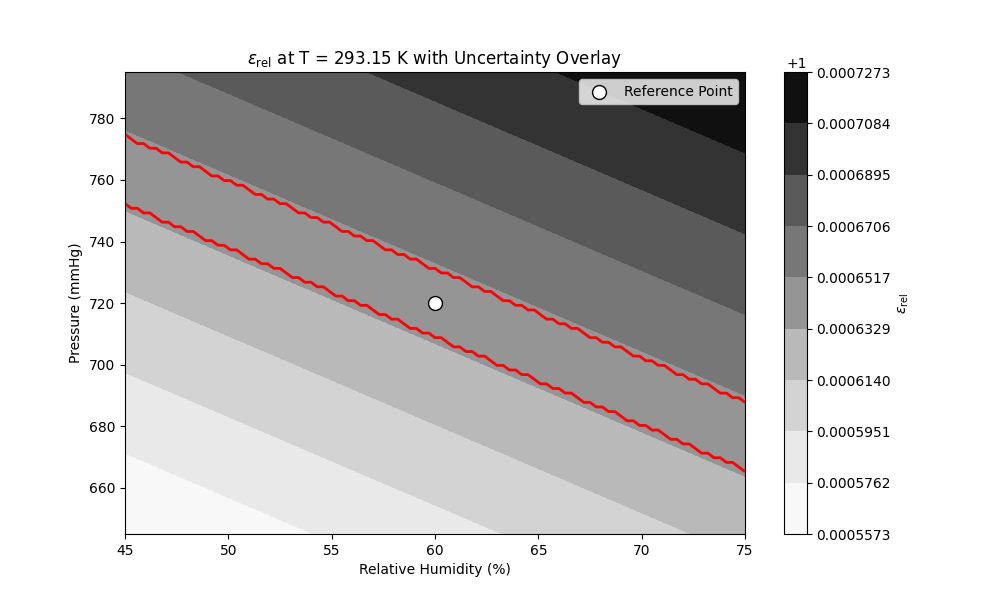

In [12]:
# Simple contour plot function with uncertainty overlay
# Simple contour plot function with uncertainty overlay
def plot_contours_with_uncertainty(
    X, Y, Z, ref_value, delta_ref, RH_ref, P_mmHg_ref, xlabel, ylabel, title
):
    """
    Plot contours with an overlay showing the uncertainty region clearly.

    Parameters:
    X : ndarray
        X-axis values (e.g., Relative Humidity).
    Y : ndarray
        Y-axis values (e.g., Pressure).
    Z : ndarray
        Z-axis values (e.g., Relative Permittivity).
    ref_value : float
        Reference value for Z (e.g., reference permittivity).
    delta_ref : float
        Uncertainty range for Z (e.g., delta permittivity).
    RH_ref : float
        Reference value for X-axis (e.g., reference RH).
    P_mmHg_ref : float
        Reference value for Y-axis (e.g., reference Pressure).
    xlabel : str
        Label for X-axis.
    ylabel : str
        Label for Y-axis.
    title : str
        Plot title.
    """
    plt.figure(figsize=(10, 6))

    # Plot the relative permittivity
    levels = np.linspace(np.min(Z), np.max(Z), 10)  # Dynamically set levels
    cp = plt.contourf(X, Y, Z, levels=levels, cmap='Greys')
    plt.colorbar(cp, label=r'$\varepsilon_{\text{rel}}$')

    # Define bounds for the uncertainty region
    lower_bound = ref_value - delta_ref
    upper_bound = ref_value + delta_ref

    within_bounds = (Z >= lower_bound) & (Z <= upper_bound)

    print(f'lower bound: {lower_bound}, upper bound: {upper_bound}')
    print(f'reference_value: " {ref_value}+-{delta_ref}')

    # Add contour line to show boundary of the uncertainty region
    plt.contour(X, Y, within_bounds.astype(float), levels=[0.5], colors='red', linewidths=2, label='Uncertainty Region')

    # Mark the reference point
    plt.scatter(RH_ref, P_mmHg_ref, color='white', edgecolor='black', s=100, label='Reference Point')

    # Titles and labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Example Input
# Reference conditions - point
RH_ref = 60  # % RH
T_K_ref = 293.15  # K 
P_mmHg_ref = 96 * 7.50062  # mmHg

fixed_T_idx = np.argmin(np.abs(T_K_range - T_K_ref))  # Fixed temperature index - closest
print(f'Temp index: {fixed_T_idx}')
print(f'temp value: {T_K_range[fixed_T_idx]} when provided: {T_K_ref}')
print(T_K_range)

# calculation of reference values:
ref_eps, ref_delta_eps = ucf.calculate_rel_eps_with_uncertainty(RH_ref, T_K_ref, P_mmHg_ref, delta_RH, delta_T, delta_P)

# Plot contours with uncertainty overlay
plot_contours_with_uncertainty(
    X = RH_range,
    Y = P_mmHg_range,
    Z = eps_rel_grid[fixed_T_idx, :, :].T,  # Transpose to align dimensions
    ref_value=ref_eps,
    delta_ref = ref_delta_eps,
    RH_ref = RH_ref, 
    P_mmHg_ref = P_mmHg_ref,
    xlabel='Relative Humidity (%)',
    ylabel='Pressure (mmHg)',
    title=r'$\varepsilon_\text{rel}$ at T = ' + f'{T_K_ref} K with Uncertainty Overlay'
)


In [13]:
np.max(eps_rel_grid)

np.float64(1.0007657195451711)

In [14]:
np.min(eps_rel_grid)

np.float64(1.0005425617078942)

In [15]:
ref_eps

np.float64(1.0006423011595886)

In [16]:
max_delta_eps_rel = np.max(eps_rel_grid) - np.min(eps_rel_grid)
print(max_delta_eps_rel)

0.00022315783727688832


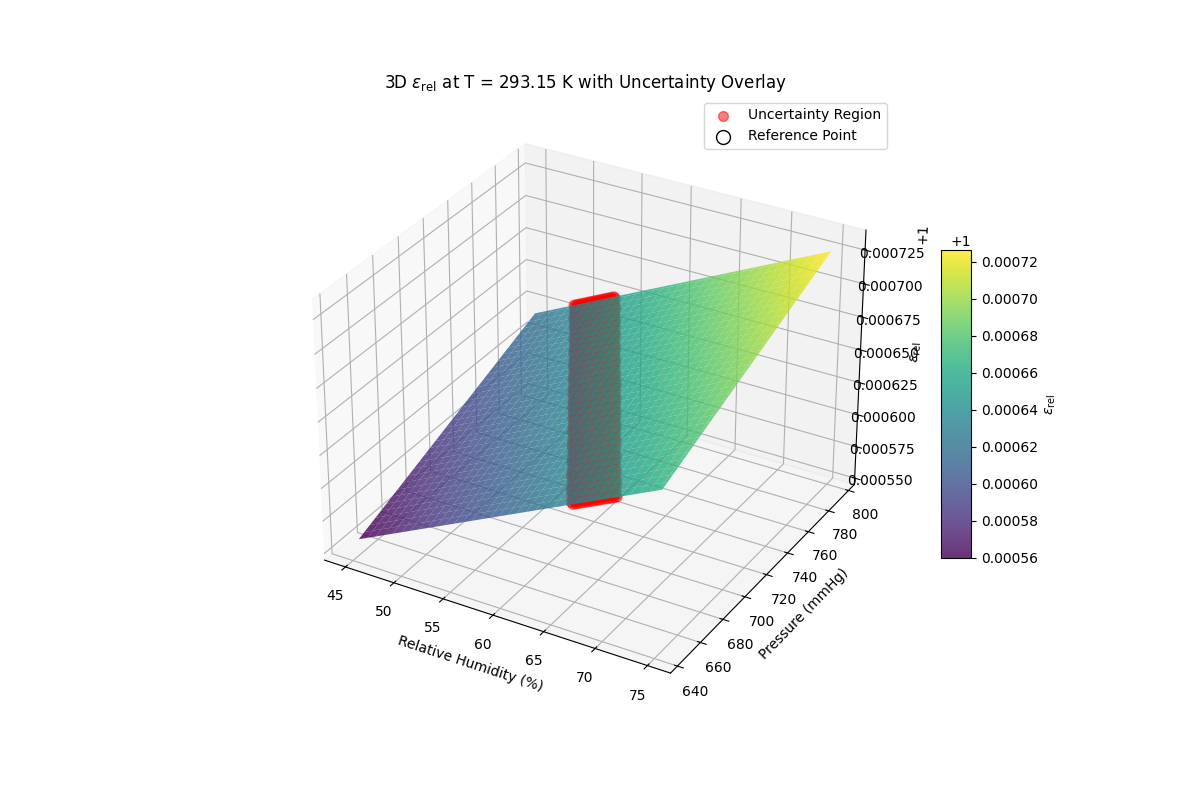

In [17]:
def plot_3D_with_uncertainty(
    X, Y, Z, ref_value, delta_ref, RH_ref, P_mmHg_ref, xlabel, ylabel, zlabel, title
):
    """
    Plot a 3D surface with uncertainty region around the reference point.

    Parameters:
    X : ndarray
        X-axis values (e.g., Relative Humidity).
    Y : ndarray
        Y-axis values (e.g., Pressure).
    Z : ndarray
        Z-axis values (e.g., Relative Permittivity).
    ref_value : float
        Reference value for Z (e.g., reference permittivity).
    delta_ref : float
        Uncertainty range for Z (e.g., delta permittivity).
    RH_ref : float
        Reference value for X-axis (e.g., reference RH).
    P_mmHg_ref : float
        Reference value for Y-axis (e.g., reference Pressure).
    xlabel : str
        Label for X-axis.
    ylabel : str
        Label for Y-axis.
    zlabel : str
        Label for Z-axis.
    title : str
        Plot title.
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create the surface plot for relative permittivity
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

    # Overlay uncertainty region
    lower_bound = ref_value - delta_ref
    upper_bound = ref_value + delta_ref
    within_bounds = (Z >= lower_bound) & (Z <= upper_bound)

    # Add points for the uncertainty region
    ax.scatter(
        X[within_bounds], Y[within_bounds], Z[within_bounds],
        color='red', s=50, alpha=0.5, label='Uncertainty Region'
    )

    # Mark the reference point
    ax.scatter(
        RH_ref, P_mmHg_ref, ref_value, color='white', edgecolor='black', s=100, label='Reference Point'
    )

    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)

    # Add legend
    ax.legend()
    plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label=r'$\varepsilon_{\text{rel}}$')
    plt.show()


# 3D Plot
plot_3D_with_uncertainty(
    X=RH_range,
    Y=P_mmHg_range,
    Z=eps_rel_grid[fixed_T_idx, :, :],
    ref_value=ref_eps,
    delta_ref=ref_delta_eps,
    RH_ref=RH_ref,
    P_mmHg_ref=P_mmHg_ref,
    xlabel='Relative Humidity (%)',
    ylabel='Pressure (mmHg)',
    zlabel=r'$\varepsilon_{\text{rel}}$',
    title=r'3D $\varepsilon_\text{rel}$ at T = ' + f'{T_K_ref} K with Uncertainty Overlay'
)

In [39]:
### Constants and calibration data
c = 3e8  # Speed of light (m/s)

delta_L_ruler = delta_L

# delta_random_level_sensor = 0.5e-3  # Distance uncertainty, random component (m) # independent from the distance
# N_obs_averaging = 10
# delta_random_level_sensor = delta_random_level_sensor / np.sqrt(N_obs_averaging)
# # transforming to time uncertainty
# delta_t_est = 2 * delta_random_level_sensor / c  # Uncertainty in time (s), random component
# constant randomness for time estimation uncertainty
# delta_t_cal = delta_t_est * np.ones_like(L_cal) #time uncertainty estimation (independent from the distance)

# Calibration table
L_cal = np.linspace(start=0.1, stop = 20, num = 21)
t_cal = 2 * L_cal / c * np.sqrt(ref_eps)

print('knots in distance:', L_cal)
print('knots in time:', t_cal)

###
### 
###

# nonlinear function for random time est...
delta_L_random_initial = 0.4e-3  # Initial random error at L_cal[0] (m)
delta_L_random_final = 1.0e-3  # Final random error at L_cal[-1] (m)

# Model delta_L_random as an exponential function: delta_L_random = A * exp(B * L_cal)
# Known boundary conditions:
# delta_L_random_initial = A * exp(B * L_cal[0])
# delta_L_random_final = A * exp(B * L_cal[-1])

# Solve for A and B
L_start = L_cal[0]
L_end = L_cal[-1]

# System of equations for A and B, we derive:
B = np.log(delta_L_random_final / delta_L_random_initial) / (L_end - L_start)
A = delta_L_random_initial / np.exp(B * L_start)

# Generate delta_L_random array
delta_L_random = A * np.exp(B * L_cal)
print('Uncertainty in level due to randomness', delta_L_random)
# after averaging & noise reduction
N_obs_averaging = 10
delta_L_random = delta_L_random / np.sqrt(N_obs_averaging)
print('After averaging & noise reduction, N = ' , N_obs_averaging)
print('after noise reduction', delta_L_random)

# conversion from distance to unc in time
delta_t_cal = 2 * delta_L_random / c  
print('Uncertainty in time delay estimation (random): ', delta_t_cal)

eps_meas = ref_eps
#eps_meas = np.max(eps_rel_grid)

print()
print('Value of epsilon during measurement:', eps_meas)
print('While for reference: ', ref_eps)
print(f"Difference in epsilon: {eps_meas - ref_eps}")
# eps_meas = np.min(eps_rel_grid)

#  distance 
L_actual = 1.0 # m

# Measured time
t_est = 2 * L_actual / c * np.sqrt(eps_meas)   # Measured time (s)
print(f'Estimated time: ', t_est, 's')
t_est_ref = 2 * L_actual / c * np.sqrt(ref_eps)   # ref time (s)
print(f'Estimated time (ref): ', t_est_ref, 's')

print(f'Direct distance estimation: {ucf.calc_level_by_time_eps(t_est_ref, ref_eps, c)}, {ucf.calc_level_by_time_eps(t_est, ref_eps, c)}')

# Find the calibration segment (segment index)
i = np.searchsorted(t_cal, t_est) - 1
i = max(0, min(i, len(L_cal) - 2))  # Ensure index is within valid bounds
print('segment of the calibration curve:', i)

# Perform interpolation, level estimation
L_est = L_cal[i] + (L_cal[i + 1] - L_cal[i]) / (t_cal[i + 1] - t_cal[i]) * (t_est - t_cal[i])
# generate corresponfing latex formula here:

# noise in time - interpolating data in table delta_t_cal, for current distance/level
# Interpolate time uncertainty from the table

delta_t_est = np.interp(t_est, t_cal, delta_t_cal)
print("Interpolated uncertainty in time calculation", delta_t_est)

print('Actual level: ', L_actual)
print('Estimated level: ', L_est)


knots in distance: [ 0.1    1.095  2.09   3.085  4.08   5.075  6.07   7.065  8.06   9.055
 10.05  11.045 12.04  13.035 14.03  15.025 16.02  17.015 18.01  19.005
 20.   ]
knots in time: [6.66880733e-10 7.30234402e-09 1.39378073e-08 2.05732706e-08
 2.72087339e-08 3.38441972e-08 4.04796605e-08 4.71151238e-08
 5.37505871e-08 6.03860503e-08 6.70215136e-08 7.36569769e-08
 8.02924402e-08 8.69279035e-08 9.35633668e-08 1.00198830e-07
 1.06834293e-07 1.13469757e-07 1.20105220e-07 1.26740683e-07
 1.33376147e-07]
Uncertainty in level due to randomness [0.0004     0.00041875 0.00043838 0.00045893 0.00048045 0.00050297
 0.00052655 0.00055124 0.00057708 0.00060413 0.00063246 0.00066211
 0.00069314 0.00072564 0.00075966 0.00079527 0.00083255 0.00087158
 0.00091244 0.00095522 0.001     ]
After averaging & noise reduction, N =  10
after noise reduction [0.00012649 0.00013242 0.00013863 0.00014513 0.00015193 0.00015905
 0.00016651 0.00017432 0.00018249 0.00019104 0.0002     0.00020938
 0.00021919 0.00022

In [40]:
# Interpolation
#L_est = 4

# Partial derivatives
dL_dLi = 1 - (t_est - t_cal[i]) / (t_cal[i + 1] - t_cal[i])
dL_dLi1 = (t_est - t_cal[i]) / (t_cal[i + 1] - t_cal[i])
dL_dti = -((L_cal[i + 1] - L_cal[i]) / (t_cal[i + 1] - t_cal[i])**2) * (t_est - t_cal[i]) - (L_cal[i + 1] - L_cal[i]) / (t_cal[i + 1] - t_cal[i])
dL_dti1 = ((L_cal[i + 1] - L_cal[i]) / (t_cal[i + 1] - t_cal[i])**2) * (t_est - t_cal[i])
dL_dt_est = (L_cal[i + 1] - L_cal[i]) / (t_cal[i + 1] - t_cal[i])

# Propagate uncertainty
delta_L_est = np.sqrt(
    (dL_dLi * delta_L)**2 +
    (dL_dLi1 * delta_L)**2 +
    (dL_dti * delta_t_cal[i])**2 +
    (dL_dti1 * delta_t_cal[i + 1])**2 +
    (dL_dt_est * delta_t_est)**2
)

# Results
print(f"Estimated level: {L_est:.6f} m")
print(f"Uncertainty in level: {delta_L_est:.6f} m")

Estimated level: 1.000000 m
Uncertainty in level: 0.000405 m


/tmp/ipykernel_11561/1013752892.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


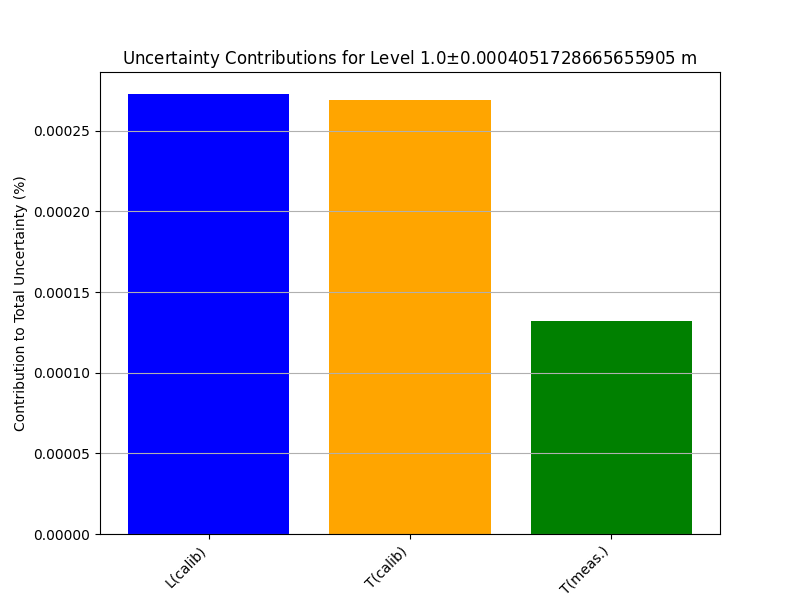

In [ ]:
# Uncertainty contributions
delta_L_contrib = (dL_dLi * delta_L)**2
delta_L1_contrib = (dL_dLi1 * delta_L)**2
delta_ti_contrib = (dL_dti * delta_t_cal[i])**2
delta_ti1_contrib = (dL_dti1 * delta_t_cal[i + 1])**2
delta_t_est_contrib = (dL_dt_est * delta_t_est)**2


# Contributions as percentages
contributions = {
    # "Distance Uncertainty (Li_calib)": np.sqrt(delta_L_contrib+delta_L1_contrib) / delta_L_est * 100,
    # "Time Uncertainty (dt_calib)": np.sqrt(delta_ti_contrib + delta_ti1_contrib )/ delta_L_est * 100,
    # 'Time unc (measurement)': np.sqrt(delta_t_est_contrib) / delta_L_est * 100

    "L(calib)": np.sqrt(delta_L_contrib+delta_L1_contrib),
    "T(calib)": np.sqrt(delta_ti_contrib + delta_ti1_contrib ),
    'delta_eps()': np.sqrt(delta_t_est_contrib)
}


plt.figure(figsize=(8, 6))
labels = list(contributions.keys())
values = list(contributions.values())
    
plt.bar(labels, values, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title(f"Uncertainty Contributions for Level {L_actual:.1f}" +"$\pm$" + f'{delta_L_est} m')
plt.ylabel("Contribution to Total Uncertainty (%)")
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

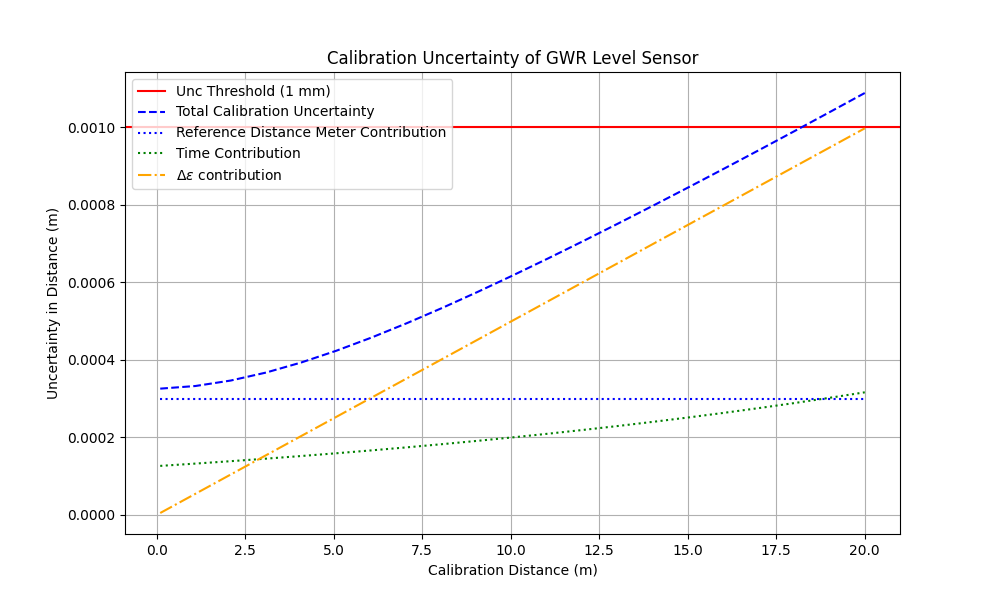

In [48]:
# Uncertainty components

delta_eps = ref_delta_eps
delta_eps = np.abs(np.min(eps_rel_grid) - ref_eps)

# Uncertainty contributions
delta_L_t = (c / (2 * np.sqrt(ref_eps))) * delta_t_cal  # Due to time uncertainty
delta_L_eps = (c * t_cal) / (4 * (ref_eps**(3/2))) * delta_eps  # Due to permittivity variation
delta_L_ruler = delta_L_ruler * np.ones_like(t_cal)

# Total uncertainty
delta_L_total = np.sqrt(delta_L_ruler**2 + delta_L_t**2 + delta_L_eps**2)

# Plot the calibration uncertainty
plt.figure(figsize=(10, 6))
plt.axhline(1e-3, color="red", linestyle="-", linewidth=1.5, label="Unc Threshold (1 mm)")
plt.plot(L_cal, delta_L_total, label="Total Calibration Uncertainty", color="blue", linestyle="--")
plt.plot(L_cal, delta_L_ruler, label="Reference Distance Meter Contribution", color="blue", linestyle=":")
plt.plot(L_cal, delta_L_t, label="Time Contribution", color="green", linestyle=":")
plt.plot(L_cal, delta_L_eps, label=f"$\Delta\epsilon$ contribution", color="orange", linestyle="-.")
plt.xlabel("Calibration Distance (m)")
plt.ylabel("Uncertainty in Distance (m)")
plt.title("Calibration Uncertainty of GWR Level Sensor")
plt.legend()
plt.grid()
plt.show()